In [38]:
def old_HOG(image, cell_size=(8, 8), block_size=(2, 2), bins=9):
    # Chia ảnh thành các ô
    h, w = image.shape
    cells_x = w // cell_size[1]
    cells_y = h // cell_size[0]
    
    # Tính toán histogram cho mỗi ô
    hist = np.zeros((cells_y, cells_x, bins), dtype=np.float32)
    for i in range(cells_y):
        for j in range(cells_x):
            cell = image[i*cell_size[0]:(i+1)*cell_size[0], j*cell_size[1]:(j+1)*cell_size[1]]
            hist[i, j] = np.histogram(cell, bins=bins, range=(0, 180))[0]

    # Chuẩn hóa histogram cho mỗi khối
    hog_features = []
    for i in range(cells_y - block_size[0] + 1):
        for j in range(cells_x - block_size[1] + 1):
            block = hist[i:i+block_size[0], j:j+block_size[1]].flatten()
            norm_block = block / np.linalg.norm(block) if np.linalg.norm(block) > 0 else block
            hog_features.append(norm_block)

    return np.array(hog_features).flatten()

## Human Detection 

# GetData

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [40]:
DataPath = './WiSARD_Multi_Modal_Sample/210417_MtErie_Enterprise_IR_0004'

def GetData(path):
    imgs = []
    labelbox = []
    for file in os.listdir(path):
        if file.split('.')[-1] == 'jpeg':
            imgs.append(os.path.join(path, file))
        else:
            labelbox.append(os.path.join(path, file))
    return imgs, labelbox

In [41]:
imgs, label = GetData(DataPath)

In [42]:
len(imgs), len(label)

(264, 265)

# Drawing boundingbox for data train

In [43]:
def GetImgs(imgs = imgs):
    data = []
    for img in imgs:
        image = cv2.imread(img)
        data.append(image)
    return data

In [44]:
def GetLabelCoord(labelbox):
    labels = []
    for file in labelbox:
        with open(file, 'r') as f:
            lines = f.readlines()
            temp = []
            for line in lines:
                line = line.strip()
                temp.append((line.split(' ')[1:]))
            labels.append(temp)
            temp = []
    return labels

In [45]:
def GetImgsBB(data, label = label):
    data_cp = []
    bboxes = []
    labelsCoord = GetLabelCoord(label)
    for index, image in enumerate(data):
        height, width = image.shape[0], image.shape[1]
        temp = []
        image_copy = image.copy()
        for bbox in labelsCoord[index]:
            if len(bbox) >= 4:
                x_center, y_center, w, h = (float(bbox[0])*width, float(bbox[1])*height, float(bbox[2])*width, float(bbox[3])*height)
                x_min = int(x_center - w/2)
                y_min = int(y_center - h/2)
                x_max = int(x_center + w/2)
                y_max = int(y_center + h/2)
                temp.append((x_min, y_min, x_max, y_max))
                cv2.rectangle(image_copy, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=10)
        bboxes.append(temp)
        data_cp.append(image_copy)
    return data_cp, bboxes
                    

        

In [46]:
data = GetImgs()

In [47]:
data__bb, bboxes = GetImgsBB(data)

In [48]:
len(data[0])

512

In [49]:
len(data__bb), len(bboxes)

(264, 264)

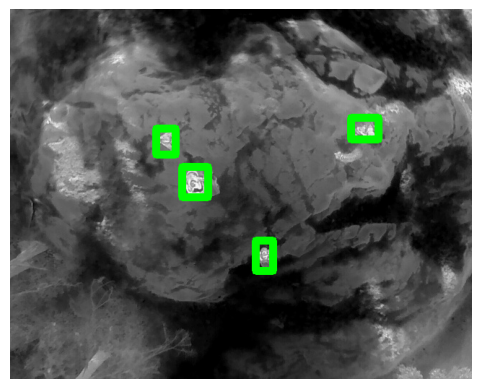

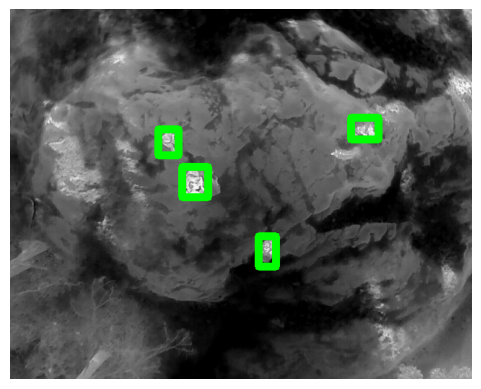

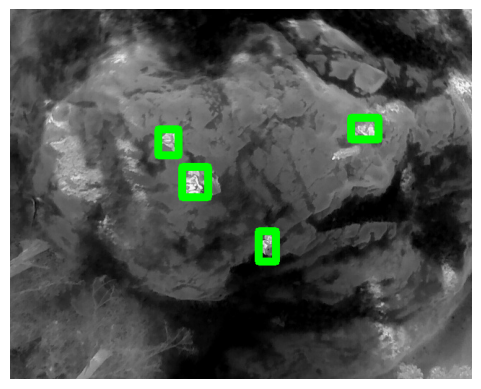

In [50]:
for img in data__bb[:3]:
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Get the cropped Image for model

In [51]:
def CropImg(imgs, bboxes):
    crops = []
    for index, img in enumerate(imgs):
        for bbox in bboxes[index]:
            x_min, y_min, x_max, y_max = bbox
            crop = img[y_min:y_max, x_min:x_max]
            crops.append(crop)
    return crops

In [52]:

data_crop = CropImg(data, bboxes)

In [53]:
len(data_crop)

1006

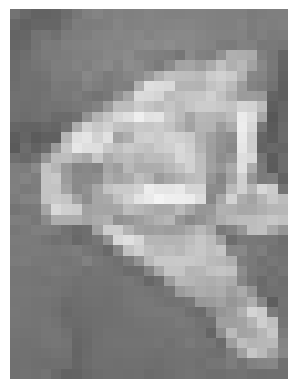

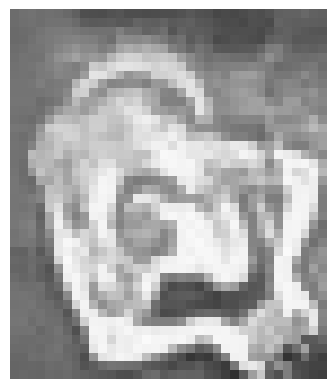

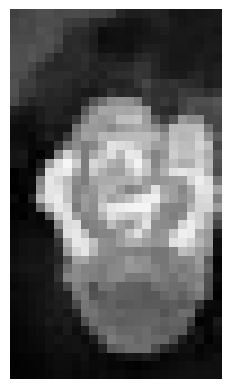

In [54]:
for img in data_crop[:3]:
    plt.imshow(img)
    plt.axis('off')
    plt.show()

non-human label

In [55]:
def CheckOverlayBB(crops, bboxes):
    x_min_crop, y_min_crop, x_max_crop, y_max_crop = crops
    for bbox in bboxes:
        x_min_box, y_min_box, x_max_box, y_max_box = bbox
        if (x_max_crop >= x_min_box and x_min_crop <= x_max_box and 
            y_max_crop >= y_min_box and y_min_crop <= y_max_box):
            return False
    return True


In [56]:
def GetImgsBBNonHuman(data, bboxes_crop, num_samples=4, min_size=40, max_size=80):
    random_bbs = []
    for index, img in enumerate(data):
        height, width = img.shape[0], img.shape[1]
        temp = []
        i = 1
        while (i<=num_samples):
            x_min = random.randint(0, width - 40)
            y_min = random.randint(0, height - 40)
            x_max = random.randint(x_min + 40, 
                                   width if (x_min + min_size + max_size) > width else x_min + min_size + max_size)
            y_max = random.randint(y_min + 40, 
                                   height if (y_min + min_size + max_size) > height else y_min + min_size + max_size)
            if CheckOverlayBB((x_min, y_min, x_max, y_max), bboxes_crop[index]):
                temp.append((x_min, y_min, x_max, y_max))
                i+=1
        random_bbs.append(temp)
    return random_bbs

In [57]:
random_bbs_non_human = GetImgsBBNonHuman(data, bboxes)

In [58]:
len(random_bbs_non_human)

264

In [59]:
data_non_human = CropImg(data, random_bbs_non_human)

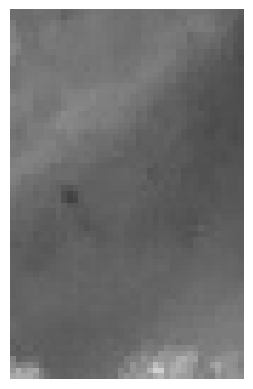

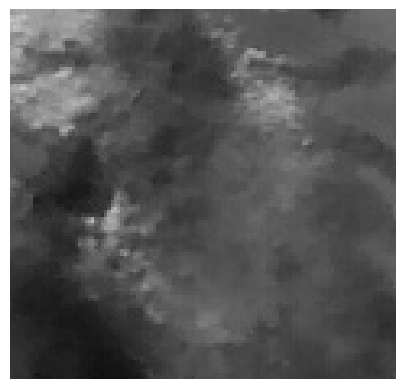

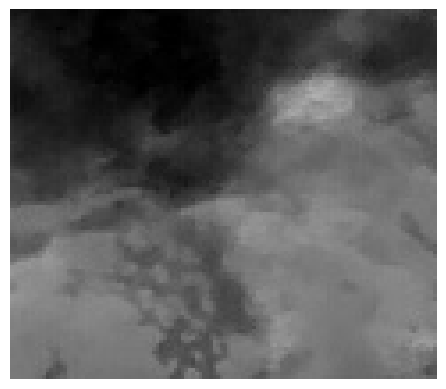

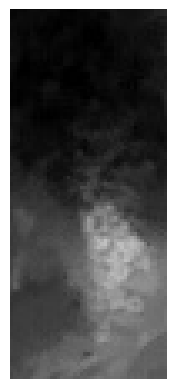

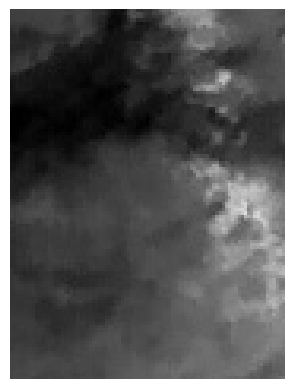

In [60]:
for img in data_non_human[:5]:
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [61]:
len(data_non_human), len(data_crop)

(1056, 1006)

In [62]:
data_non_human[0].shape, data_crop[0].shape

((65, 41, 3), (36, 27, 3))

In [63]:
label = len(data_non_human)* [1] + len(data_crop)*[0]
label = np.array(label)

data_combined = data_non_human + data_crop
len(data_combined),len(label)

(2062, 2062)

## PREPROCESSING

1. Resize image

In [64]:
for index,val in enumerate(data_combined):
    val = cv2.cvtColor(val, cv2.COLOR_BGR2GRAY)
    data_combined[index] = cv2.resize(val, (40, 40))

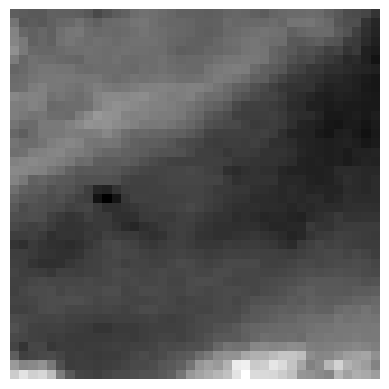

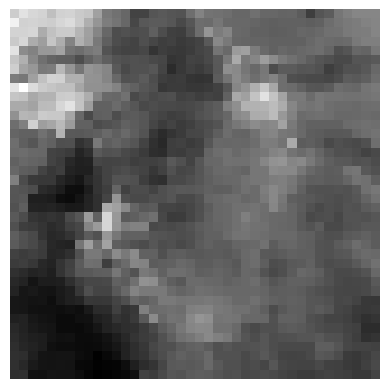

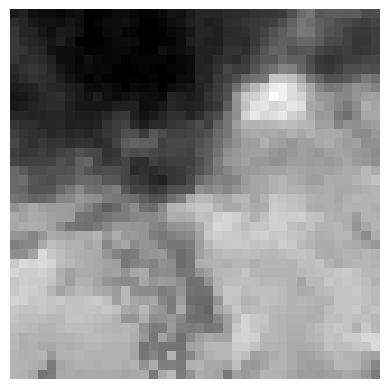

In [65]:
for img in data_combined[:3]:
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

2. Normalization

In [66]:
data_combined[0]

array([[110, 109, 108, ..., 101,  99,  91],
       [120, 107, 109, ..., 103,  90,  84],
       [127, 114, 112, ...,  96,  88,  83],
       ...,
       [110,  96,  98, ..., 141, 143, 133],
       [138, 128, 130, ..., 144, 139, 127],
       [161, 172, 163, ..., 147, 145, 139]], dtype=uint8)

In [67]:
def NormalizeData(data_combined):
    data = []
    for img in data_combined:
        img = cv2.resize(img, (40, 40))
        img = img.astype('float32')
        img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
        data.append(img)
    return data

In [68]:
data_normalize = NormalizeData(data_combined)

In [69]:
data_normalize[0]

array([[0.3697479 , 0.36134455, 0.3529412 , ..., 0.29411766, 0.27731094,
        0.21008405],
       [0.45378155, 0.34453782, 0.36134455, ..., 0.31092438, 0.20168069,
        0.15126051],
       [0.5126051 , 0.40336138, 0.38655466, ..., 0.25210086, 0.18487397,
        0.14285715],
       ...,
       [0.3697479 , 0.25210086, 0.26890758, ..., 0.6302521 , 0.64705884,
        0.56302524],
       [0.60504204, 0.52100843, 0.53781515, ..., 0.6554622 , 0.6134454 ,
        0.5126051 ],
       [0.7983194 , 0.89075637, 0.8151261 , ..., 0.6806723 , 0.66386557,
        0.6134454 ]], dtype=float32)

## MODEL

1. HOG

In [70]:
def padding(img_pre):
    img_pad = np.zeros((img_pre.shape[0] + 2, img_pre.shape[1] + 2), dtype=np.float32)
    img_pad[1:-1, 1:-1] = img_pre
    img_pad[0,1:-1] = img_pre[1,:] # paddign trên
    img_pad[-1,1:-1] = img_pre[-2,:] # padding dưới
    img_pad[1:-1,0] = img_pre[:,1] # padding trái
    img_pad[1:-1,-1] = img_pre[:,-2] # padding phải
    img_pad[0,0] = img_pad[0,2] # padding trên trái
    img_pad[0,-1] = img_pad[0,-3] # padding trên phải
    img_pad[-1,0] = img_pad[-1,2] # padding dưới trái
    img_pad[-1,-1] = img_pad[-1,-3] # padding dưới phải
    return img_pad

In [75]:
def Gradient(img_pre):
    h, w = img_pre.shape
    img_pad = padding(img_pre)
    gradient_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    gradient_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    img_gradient_direction = np.zeros((h, w), dtype=np.float32)
    img_gradient_magnitude = np.zeros((h, w), dtype=np.float32)
    img_cp = np.zeros((3, 3), dtype=np.float32)
    for i in range(1,h+1):
        for j in range(1,w+1):
            img_cp = img_pad[i-1:i+2, j-1:j+2] # Th binh thuong
            gradient_x_value = np.sum(img_cp * gradient_x)
            gradient_y_value = np.sum(img_cp * gradient_y)
            img_gradient_direction[i-1, j-1] = abs(np.arctan2(gradient_y_value, gradient_x_value) * 180 / np.pi)
            img_gradient_magnitude[i-1, j-1] = np.sqrt(gradient_x_value**2 + gradient_y_value**2)
            
    return img_gradient_direction, img_gradient_magnitude

In [72]:
data_gradient_direction, data_gradient_magnitude = Gradient(data_normalize[0])
data_gradient_direction.shape, data_gradient_magnitude.shape

((40, 40), (40, 40))

In [79]:
def Histogram(img_gradient_direction, img_gradient_magnitude, bins=9):
    h, w = img_gradient_direction.shape
    bin_width = 180 / bins
    histogram = np.zeros((bins), dtype=np.float32)
    for i in range(h):
        for j in range(w):
            index = np.floor(img_gradient_direction[i, j] / 180 * bins).astype(int)
            left_affect = (bin_width*(index+1)-img_gradient_direction[i, j]) / bin_width
            right_affect = (img_gradient_direction[i, j]-bin_width*index) / bin_width
            histogram[index%bins] += img_gradient_magnitude[i, j] * left_affect
            histogram[(index+1)%bins] += img_gradient_magnitude[i, j] * right_affect
    return histogram

In [77]:
def HOG(data_direction, data_magnitude, cell_size=(8, 8), block_size=(2, 2), bins=9):
    h, w = data_direction.shape
    cells_x = w // cell_size[1]
    cells_y = h // cell_size[0]
    
    hist = np.zeros((cells_y, cells_x, bins), dtype=np.float32)
    for i in range(cells_y):
        for j in range(cells_x):
            cell_dir = data_direction[i*cell_size[0]:(i+1)*cell_size[0], j*cell_size[1]:(j+1)*cell_size[1]]
            cell_mag = data_magnitude[i*cell_size[0]:(i+1)*cell_size[0], j*cell_size[1]:(j+1)*cell_size[1]]
            hist[i, j] = Histogram(cell_dir, cell_mag, bins=bins)

    hog_features = []
    for i in range(cells_y - block_size[0] + 1):
        for j in range(cells_x - block_size[1] + 1):
            block = hist[i:i+block_size[0], j:j+block_size[1]].flatten()
            norm_block = block / np.linalg.norm(block) if np.linalg.norm(block) > 0 else block
            hog_features.append(norm_block)

    return np.array(hog_features).flatten()

In [80]:
hog_result = HOG(data_gradient_direction, data_gradient_magnitude)
hog_result.shape

(576,)